In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [2]:
filepath = "/home/veroastro/Documents/NASA_POWER_ds/data/"
df = pd.read_csv(filepath + "POWER_Point_Hourly_20010101_20211231_041d39N_002d17E_UTC.csv")
df_new = df.drop(['T2MWET','T2MDEW', 'PS'], axis = 1) # dropped to deal with multicollinearity
X = df_new.drop('T2M', axis= 1)
y = df_new['T2M']
size =len(X.columns)

# create train and test indices
train, test = train_test_split(list(range(X.shape[0])), test_size= 0.3)

input_size = 11
hidden1 = 250
hidden2 = 50
output_size = 1
learning_rate = 0.01
batch_size = 5
num_epochs = 30

class PrepareData(Dataset):

    def __init__(self, X, y, scale_X=True):
        if not torch.is_tensor(X):
            if scale_X:
                X = StandardScaler().fit_transform(X)
                self.X = torch.tensor(X)
        if not torch.is_tensor(y):
            self.y = torch.tensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

ds = PrepareData(X, y=y, scale_X=True)

train_set = DataLoader(ds, batch_size=batch_size,
                       sampler=SubsetRandomSampler(train))
test_set = DataLoader(ds, batch_size=batch_size,
                      sampler=SubsetRandomSampler(test))


In [3]:
# Define a Neural Network class

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H1, H2, D_out):
        super(Net, self).__init__()
        self.linear1 = nn.Linear(D_in, H1)
        self.linear2 = nn.Linear(H1, H2)
        self.linear3 = nn.Linear(H2, D_out)

    # Prediction    
    def forward(self, x):
        x = torch.relu(self.linear1(x)) 
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

model = Net(input_size, hidden1, hidden2, output_size)

In [4]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [6]:
#training the model
epochs = 100
i = 0
useful_stuff = {'training_loss': [],'validation_error': []}  
for epoch in range(epochs):
    for i, (x, y) in enumerate(train_set):
           
        optimizer.zero_grad()
        z = model(x.view(-1,size).float())
        loss = criterion(z, y.view(-1,1).float())
        loss.backward()
        optimizer.step()
         #loss for every iteration
        useful_stuff['training_loss'].append(loss.data.item())
    correct = 0
    preds = []
    abs_zy = []
    for x, y in test_set:
            #validation 
       
        z = model(x.view(-1, size).float())
        abs_delta = np.abs(z.detach().numpy() - y.view(-1,1).detach().numpy() )
        preds.append(z) 
        abs_zy.append(abs_delta)
        correct += 1
    mae = np.mean(abs_delta)
    useful_stuff['validation_error'].append(mae)
    if epoch % 10 == 0:
        print('epoch', epoch)
       

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40
epoch 50
epoch 60
epoch 70
epoch 80
epoch 90


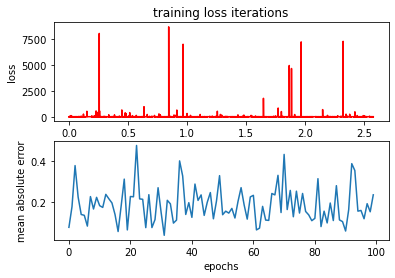

In [7]:
# plotting loss and mean absolute error
plt.subplot(2, 1, 1)
plt.plot(useful_stuff['training_loss'], 'r')
plt.ylabel('loss')
plt.title('training loss iterations')

plt.subplot(2, 1, 2)
plt.plot(useful_stuff['validation_error'])
plt.ylabel('mean absolute error')
plt.xlabel('epochs')   
plt.savefig('pytorch')
plt.show()